In [1]:
## Importing Libraries

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image

print(tf.__version__)

1.13.1


In [2]:
tf.enable_eager_execution()

In [3]:
cd '/content/gdrive/My Drive/TensorFlow_Training_12th'

In [4]:
## training에 사용할 image size
img_width = 224
img_height = 224

tf.set_random_seed(777)

In [5]:
## tfrecord file 이름과 디렉토리 설정
tfrecord_train = 'simpsons_small_train.tfrecord'
tfrecord_test = 'simpsons_small_test.tfrecord'
tfrecord_dir = 'tfrecords'

In [6]:
## tfrecord file 경로 설정
cur_dir = os.getcwd()
train_tfr_path = os.path.join(cur_dir, tfrecord_dir, tfrecord_train)
test_tfr_path = os.path.join(cur_dir, tfrecord_dir, tfrecord_test)

In [7]:
## hyper parameters
learning_rate = 0.0002
training_epochs = 30
batch_size = 16

## class 갯수
n_class = 12
## training data 수
n_train = 7488
## test data 수
n_test = 2496
## learning rate decay ratio
lr_decay_ratio = 0.1
## 몇 epoch 마다 learning rate을 decay할 것인지
lr_decay_epoch_num = 10
## image file 위치
image_dir = 'simpsons_small'

In [8]:
def _parse_function(tfrecord_serialized):
    features={'image': tf.FixedLenFeature([], tf.string),
             'label': tf.FixedLenFeature([], tf.int64)}
    parsed_features = tf.parse_single_example(tfrecord_serialized, features)
    
    image = tf.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [img_height, img_width, 3])
    image = tf.cast(image, tf.float32)/255.
    
    label = tf.cast(parsed_features['label'], tf.int32)
    label = tf.one_hot(label, depth=n_class)
    
    return image, label

In [9]:
train_dataset = tf.data.TFRecordDataset(train_tfr_path)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=8)
train_dataset = train_dataset.shuffle(buffer_size=n_train*2).prefetch(
    buffer_size=batch_size).batch(batch_size)

In [10]:
test_dataset = tf.data.TFRecordDataset(test_tfr_path)
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=8)
test_dataset = test_dataset.shuffle(buffer_size=n_train*2).prefetch(
    buffer_size=batch_size).batch(batch_size)

In [11]:
from tensorflow.keras.layers import Input, Conv2D, Dense, ReLU, BatchNormalization, MaxPool2D, GlobalAveragePooling2D

In [12]:
def create_model():
    inputs = Input(shape=(img_height, img_width, 3))
    net = Conv2D(filters=32, kernel_size=3, strides=1, padding='SAME')(inputs)
    net = BatchNormalization()(net)
    net = ReLU()(net)
    net = MaxPool2D(padding='SAME')(net)
    net = Conv2D(filters=64, kernel_size=3, strides=1, padding='SAME')(net)
    net = BatchNormalization()(net)
    net = ReLU()(net)
    net = MaxPool2D(padding='SAME')(net)
    net = Conv2D(filters=128, kernel_size=3, strides=1, padding='SAME')(net)
    net = BatchNormalization()(net)
    net = ReLU()(net)
    net = MaxPool2D(padding='SAME')(net)
    net = Conv2D(filters=256, kernel_size=3, strides=1, padding='SAME')(net)
    net = BatchNormalization()(net)
    net = ReLU()(net)
    net = MaxPool2D(padding='SAME')(net)
    net = Conv2D(filters=512, kernel_size=3, strides=1, padding='SAME')(net)
    net = BatchNormalization()(net)
    net = ReLU()(net)
    net = GlobalAveragePooling2D()(net)
    net = Dense(units=64)(net)
    net = BatchNormalization()(net)
    net = ReLU()(net)
    net = Dense(units=n_class)(net)
    return keras.Model(inputs=inputs, outputs=net)

In [13]:
model = create_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batc

In [14]:
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            logits=logits, labels=labels))    
    return loss   

In [15]:
def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

In [16]:
def evaluate(model, images, labels):
    logits = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [18]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        #print(images.shape, labels.shape)
        images = tf.image.resize(images, (img_height, img_width)) 
        grads = grad(model, images, labels)                
        optimizer.apply_gradients(zip(grads, model.variables))
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:
        images = tf.image.resize(images, (img_height, img_width)) 
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 1.60250831 train accuracy =  0.3042 test accuracy =  0.5349
Epoch: 2 loss = 0.90619588 train accuracy =  0.5948 test accuracy =  0.6290
Epoch: 3 loss = 0.62351286 train accuracy =  0.6490 test accuracy =  0.6591
Epoch: 4 loss = 0.46923512 train accuracy =  0.6763 test accuracy =  0.7452
Epoch: 5 loss = 0.36328703 train accuracy =  0.7043 test accuracy =  0.7792
Epoch: 6 loss = 0.28106144 train accuracy =  0.7106 test accuracy =  0.8021
Epoch: 7 loss = 0.21674947 train accuracy =  0.7101 test accuracy =  0.6374
Epoch: 8 loss = 0.16935460 train accuracy =  0.7210 test accuracy =  0.6943
Epoch: 9 loss = 0.13007779 train accuracy =  0.6919 test accuracy =  0.7023
Epoch: 10 loss = 0.10325524 train accuracy =  0.7181 test accuracy =  0.7316
Epoch: 11 loss = 0.07846026 train accuracy =  0.7451 test accuracy =  0.7075
Epoch: 12 loss = 0.05854828 train accuracy =  0.7381 test accuracy =  0.7520
Epoch: 13 loss = 0.05842910 train accuracy =  0.

In [19]:
data_dir = cur_dir
image_path = os.path.join(data_dir, image_dir)

class_names = sorted(os.listdir(image_path))
print(class_names)

['abraham_grampa_simpson', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum', 'homer_simpson', 'krusty_the_clown', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner', 'sideshow_bob']


In [20]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(n_class), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(n_class), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

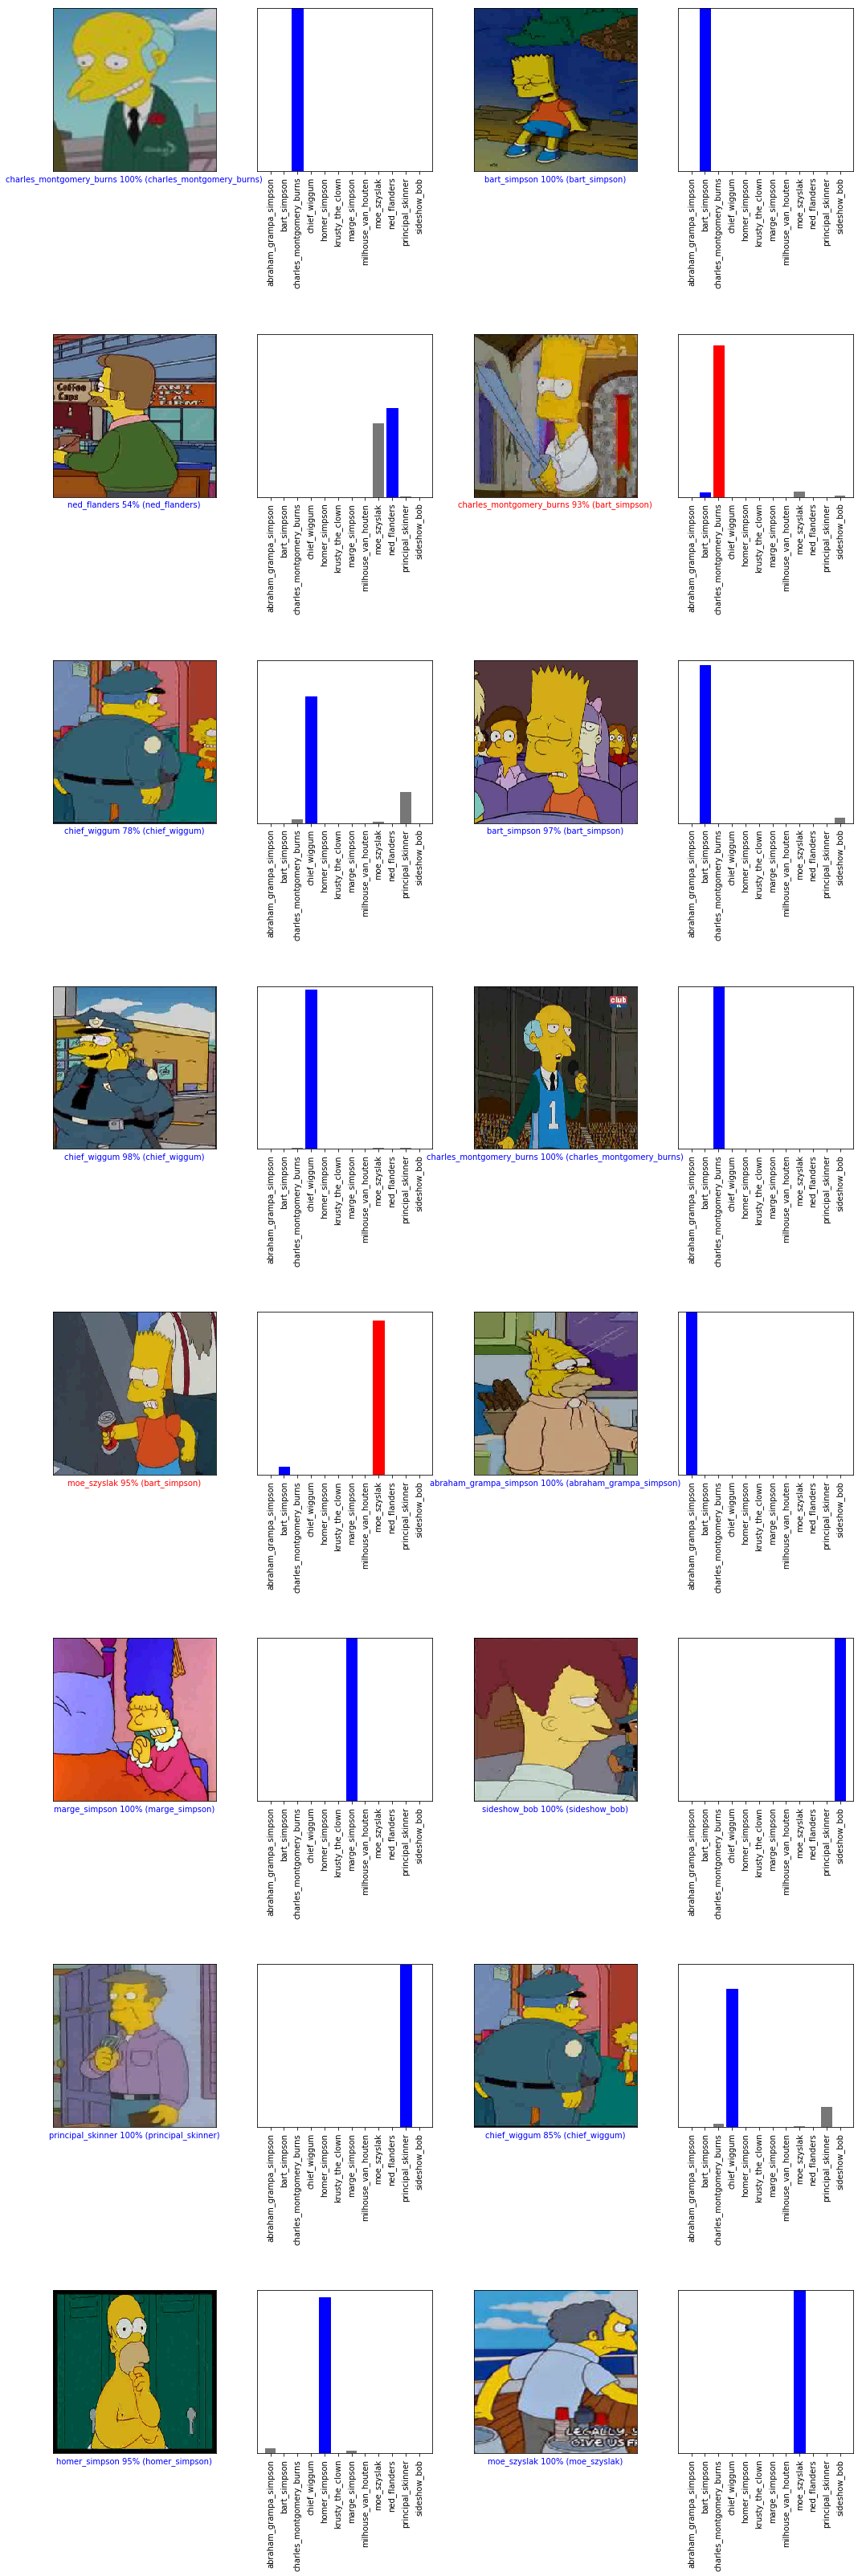

In [21]:
rnd_idx = np.random.randint(1, n_test//batch_size)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = keras.activations.softmax(model(images, training=False))    
    num_rows = 8
    num_cols = 2
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*3*num_cols, 7*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break